<a href="https://colab.research.google.com/github/lschoch/MLA_LHS/blob/main/FinalProject_Classification2_LHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Final Project - Classification**  
## **Lawrence Schoch**
## **CS430**
## **Machine Learning in the Cloud** 
---

## Introduction
The [Wisconsin Breast Cancer Database](https://archive-beta.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+diagnostic) contains 569 instances with 32 attributes. The target variable, "Diagnosis", is categorical and has two possible values, 'M' for malignant and 'B' for benign. Thus, it is predicted as a binomial classification problem. Of the remaining 31 variables, one is an identifier unique to each instance and 22 are not typically used in machine learning models. This leaves eight attributes for modeling all of which are continuous. Two models, logistic regression and random forest with grid search were implemented. 
<br><br>
Additional information from [the author's previous paper](https://github.com/lschoch/wdbc.git) using this dataset: "The Wisconsin Diagnostic Breast Cancer data set contains the data from a series of fine needle aspiration breast biopsies performed by Dr. William Wolberg, physician at the University of Wisconsin Hospital in Madison, Wisconsin, USA. It was donated in 1992 and is available to the public on the University of California Irvine Machine Learning Data Repository. To create the dataset Dr. Wolberg used fluid samples, taken from patients with solid breast masses, and an easy-to-use graphical computer program called Xcyt, which evaluates characteristics of cell nuclei present on a digital image." 
<br><br>
The data file will be submitted separately in an archive file named 'wdbc.data.zip.'

## Standard Imports

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [153]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports for Specific Models

In [154]:
# Import models.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Imports for Splitting Data and Building Pipeline


In [155]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [156]:
from sklearn import set_config
set_config(display='diagram')

## Imports for Performance Measures

In [157]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## ROC_Curve Function
This function is for plotting the roc_curve

In [158]:
def plot_roc_curve(fpr,tpr):
  plt.figure(figsize=(10, 10))
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('Recall (True Positive Rate)')


## Reading the Data

In [159]:
df = pd.read_csv("/content/gdrive/MyDrive/1CS430/wdbc.data", header=None, na_values='?')

In [160]:
# Add names for first 12 columns. The remaining columns will not be used in the model.
names = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 
         'fractal_dimension','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']
df.columns = names

## Statistical and Visual Exploration

In [161]:
# View a random sample of 10 rows of the dataframe
df.sample(10)

,ID,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,...,23,24,25,26,27,28,29,30,31,32
209,8810436,B,15.270,12.91,98.17,725.5,0.08182,0.06230,0.05892,0.03157,...,17.380,15.92,113.70,932.7,0.1222,0.2186,0.29620,0.10350,0.2320,0.07474
444,9110127,M,18.030,16.85,117.50,990.0,0.08947,0.12320,0.10900,0.06254,...,20.380,22.02,133.30,1292.0,0.1263,0.2666,0.42900,0.15350,0.2842,0.08225
172,87164,M,15.460,11.89,102.50,736.9,0.12570,0.15550,0.20320,0.10970,...,18.790,17.04,125.00,1102.0,0.1531,0.3583,0.58300,0.18270,0.3216,0.10100
214,8810955,M,14.190,23.81,92.87,610.7,0.09463,0.13060,0.11150,0.06462,...,16.860,34.85,115.00,811.3,0.1559,0.4059,0.37440,0.17720,0.4724,0.10260
538,921092,B,7.729,25.49,47.98,178.8,0.08098,0.04878,0.00000,0.00000,...,9.077,30.92,57.17,248.0,0.1256,0.0834,0.00000,0.00000,0.3058,0.09938
392,903507,M,15.490,19.97,102.40,744.7,0.11600,0.15620,0.18910,0.09113,...,21.200,29.41,142.10,1359.0,0.1681,0.3913,0.55530,0.21210,0.3187,0.10190
273,8910996,B,9.742,15.67,61.50,289.9,0.09037,0.04689,0.01103,0.01407,...,10.750,20.88,68.09,355.2,0.1467,0.0937,0.04043,0.05159,0.2841,0.08175
73,859983,M,13.800,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,...,16.570,20.86,110.30,812.4,0.1411,0.3542,0.27790,0.13830,0.2589,0.10300
357,901028,B,13.870,16.21,88.52,593.7,0.08743,0.05492,0.01502,0.02088,...,15.110,25.58,96.74,694.4,0.1153,0.1008,0.05285,0.05556,0.2362,0.07113
540,921385,B,11.540,14.44,74.65,402.9,0.09984,0.11200,0.06737,0.02594,...,12.260,19.68,78.78,457.8,0.1345,0.2118,0.17970,0.06918,0.2329,0.08134


In [162]:
# Get counts and common statistics for the dataframe.
df.describe()

,ID,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,...,23,24,25,26,27,28,29,30,31,32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [163]:
# Summarize the number of missing values in each column
df.isnull().sum()

ID                   0
Diagnosis            0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
concavity            0
concave_points       0
symmetry             0
fractal_dimension    0
13                   0
14                   0
15                   0
16                   0
17                   0
18                   0
19                   0
20                   0
21                   0
22                   0
23                   0
24                   0
25                   0
26                   0
27                   0
28                   0
29                   0
30                   0
31                   0
32                   0
dtype: int64

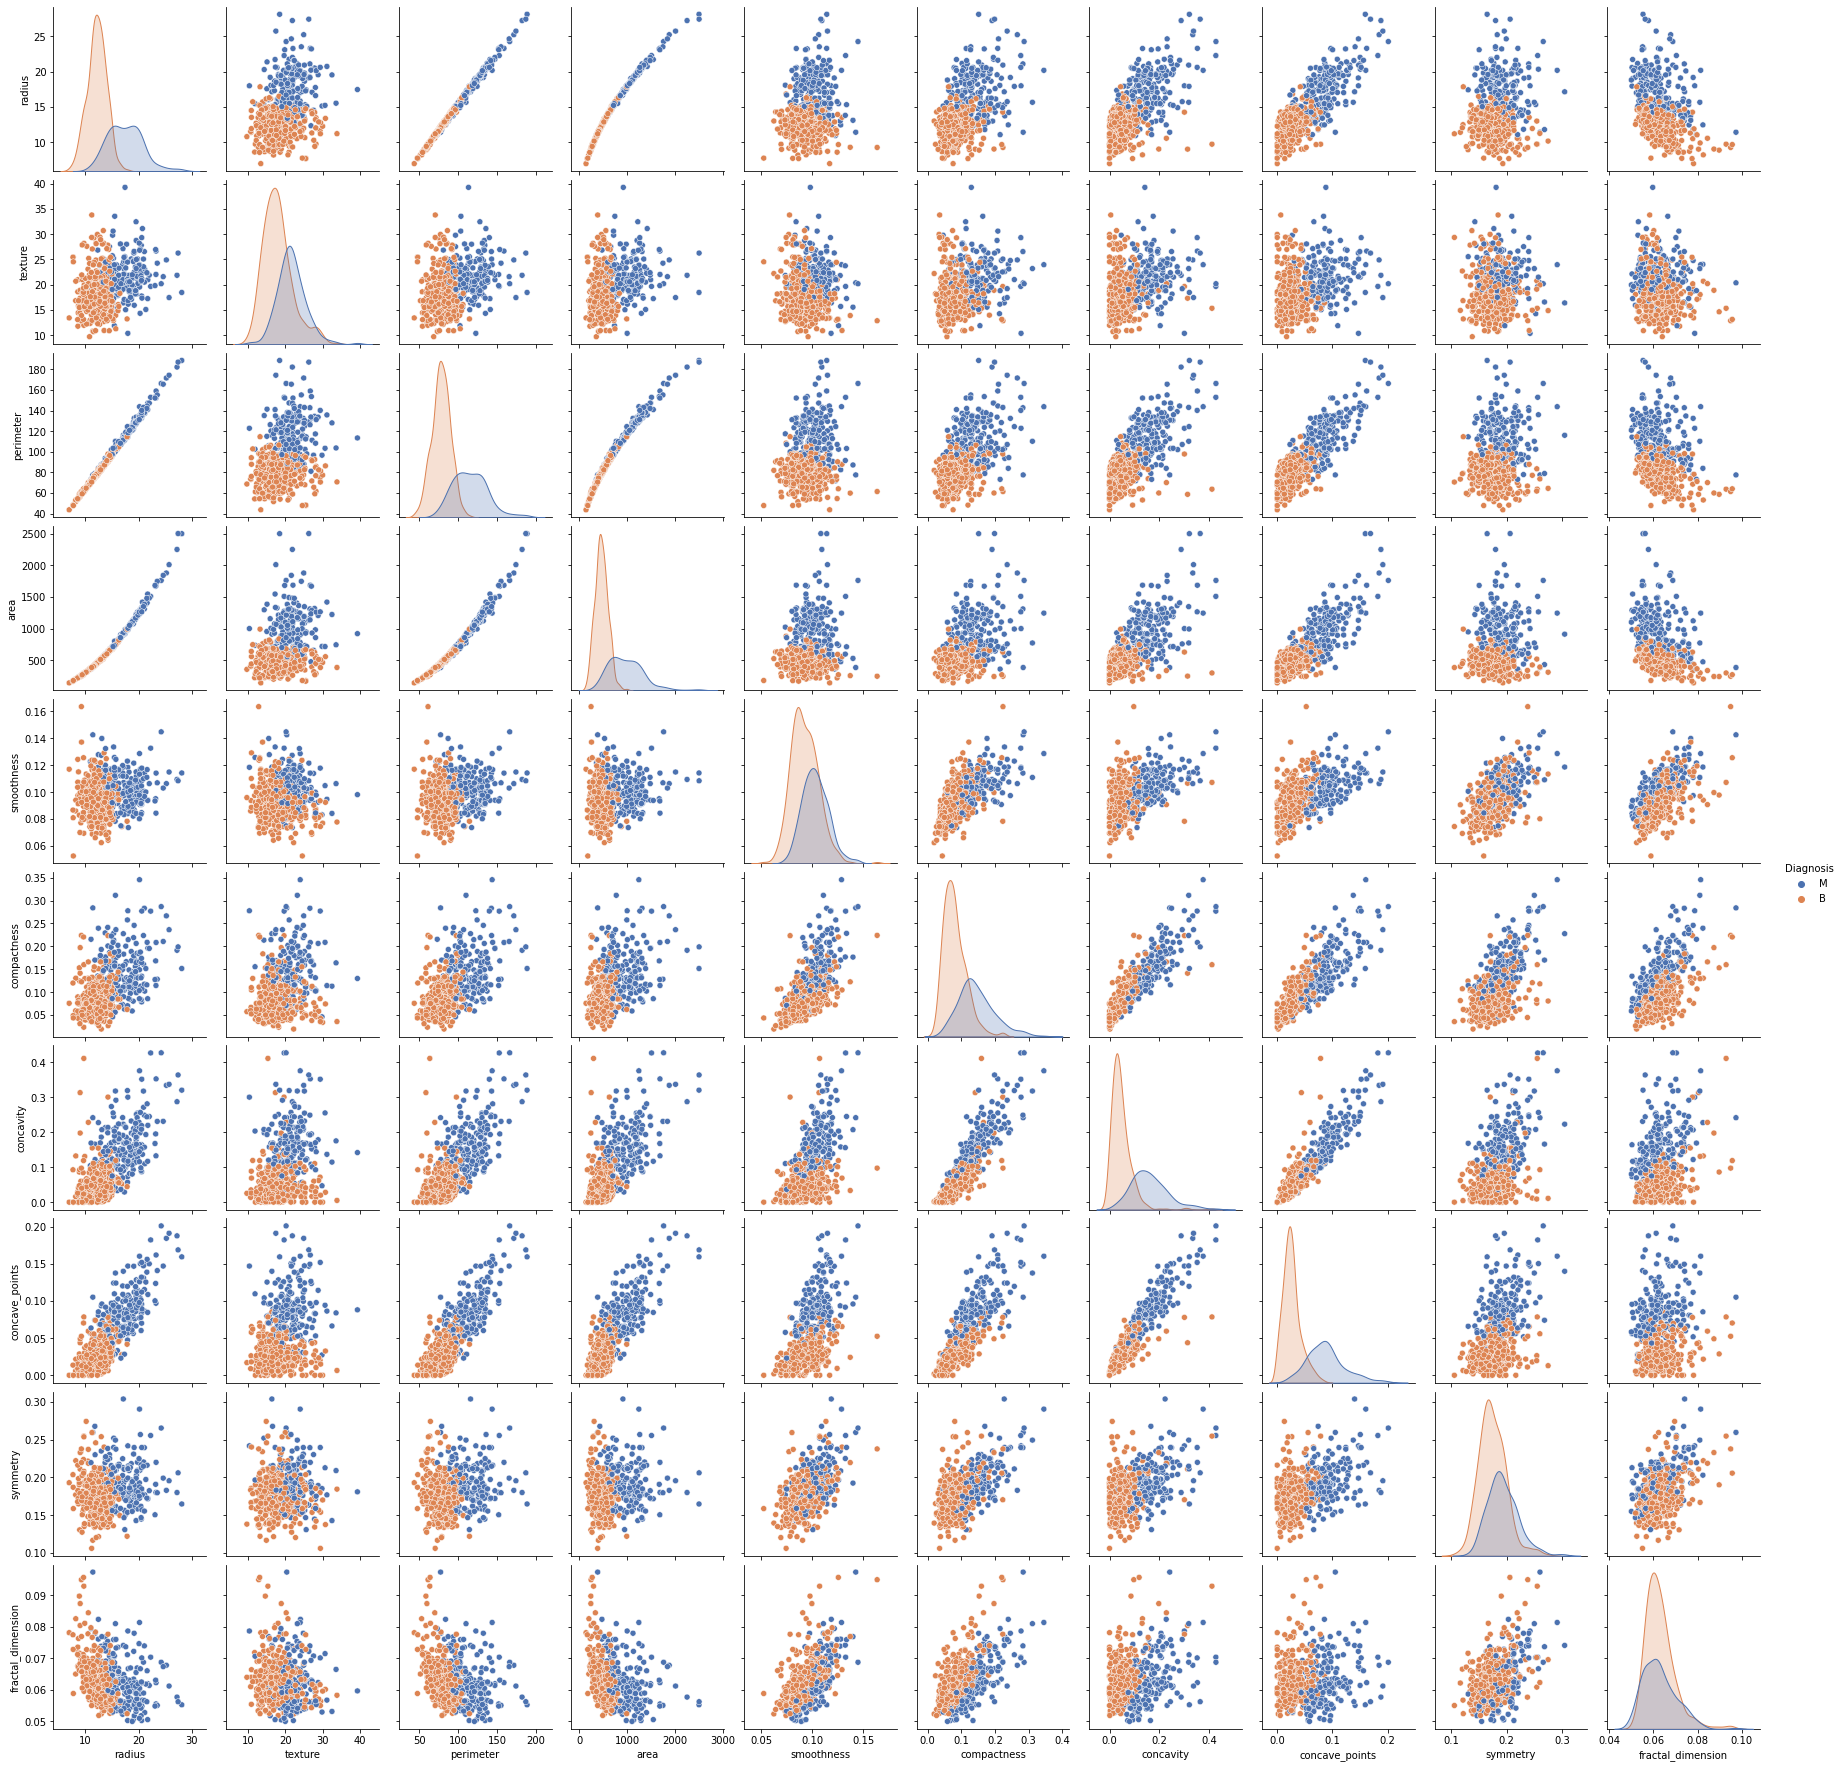

In [164]:
# Create a pairplot of all of the pertinent numerical variables using Seaborn, color-coded by load_type.
pp = sns.pairplot(df.iloc[:,1:12], hue='Diagnosis', palette = 'deep')

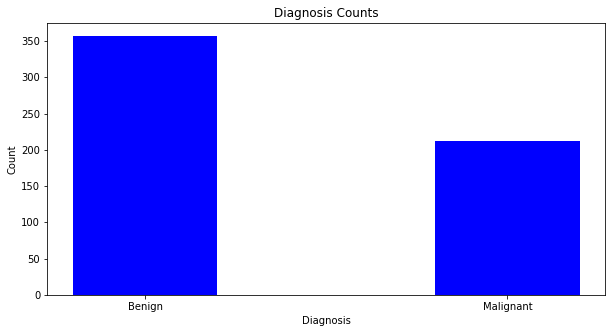

In [165]:
# Plot Diagnosis counts
fig = plt.figure(figsize = (10, 5))
# Rename Diagnosis identifiers to make them more reader-friendly
df1 = df['Diagnosis'].apply(lambda x: 'Benign' if x=='B' else 'Malignant')
dx = list(df1.value_counts().keys())
counts = list(df1.value_counts())
# creating the bar plot
plt.bar(list(dx), counts, color ='blue',
        width = 0.4)
 
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.title("Diagnosis Counts")
plt.show()

## Splitting the Data

In [166]:
df.head()

,ID,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,...,23,24,25,26,27,28,29,30,31,32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [167]:
# Recharacterize values in 'Diagnosis' column to '0' or '1'
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 1 if x=='M' else 0)
# For X drop the 'ID' column, include second through twelfth columns)
X = df.drop('ID', axis=1)
X = df.iloc[:,2:12]
y = df[['Diagnosis']]
# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [168]:
df['Diagnosis'].value_counts()

0    357
1    212
Name: Diagnosis, dtype: int64

## Building the Pipeline for a Logistic Regression Model

In [169]:
num_attribs = X_train.columns
col_transform = ColumnTransformer(transformers=[
                                 ('num',MinMaxScaler(), num_attribs)],
                                 remainder='passthrough')

In [170]:
pipeline = Pipeline(steps=[
                     ('transform', col_transform),
                     ('log_reg', LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10,max_iter=10000))
]) 
pipeline

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
       'concavity', 'concave_points', 'symmetry', 'fractal_dimension'],
      dtype='object'))])),
                ('log_reg',
                 LogisticRegression(C=10, max_iter=10000,
                                    multi_class='multinomial'))])

## Executing the Logistic RegressionModel

In [171]:
pipeline.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
       'concavity', 'concave_points', 'symmetry', 'fractal_dimension'],
      dtype='object'))])),
                ('log_reg',
                 LogisticRegression(C=10, max_iter=10000,
                                    multi_class='multinomial'))])

## Evaluating the Logistic Regression Model

In [172]:
# Make predictions on the test data.
y_pred = pipeline.predict(X_test)
# Display the precision, recall, and F1 score for each class.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        67
           1       0.96      0.91      0.93        47

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114



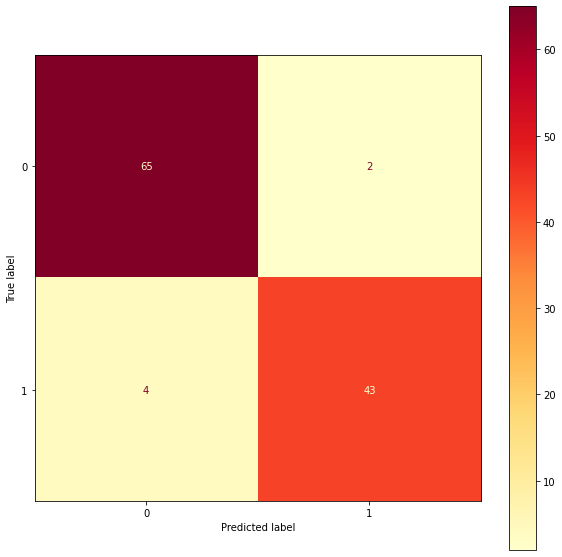

In [173]:
# Display a heat map of the confusion matrix,
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='YlOrRd')
plt.show()

                        ROC AUC: 0.9876151159098127



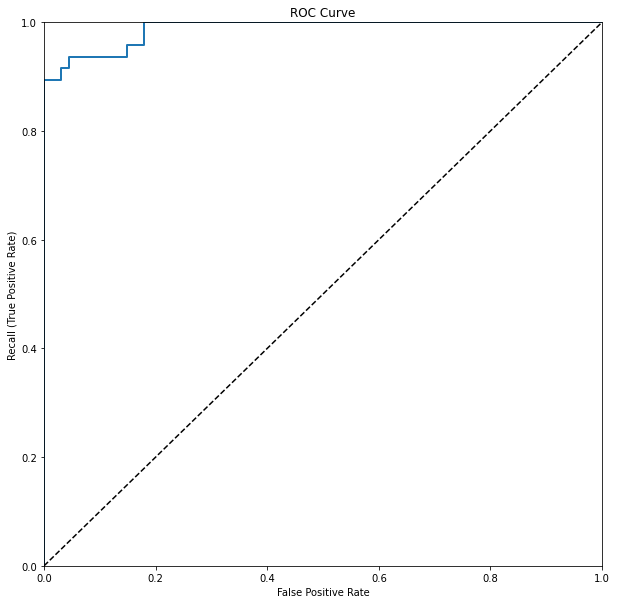

In [174]:
# Get ROC AUC and plot ROC curve.
y_pred_proba = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
print('                        ROC AUC:',roc_auc_score(y_test, y_pred_proba))
print()
plot_roc_curve(fpr, tpr)

                    AUC Precision-Recall: 0.9849610767533302



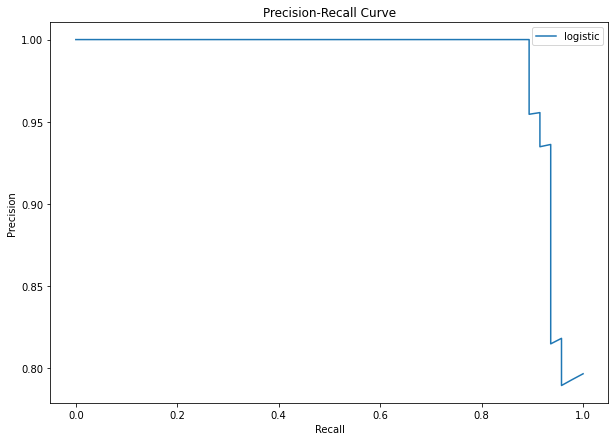

In [175]:
# Get precision-recall data.
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)
# Print AUC of precision-recall curve
print('                    AUC Precision-Recall:', auc(lr_recall, lr_precision))
print()
# Plot precision vs recall
plt.figure(figsize=(10, 7))
plt.title('Precision-Recall Curve')
plt.plot(lr_recall, lr_precision, label='logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Building the Pipeline for a Random Forest Model with Grid Search

In [176]:

# Define pipeline
pipeline2 = Pipeline(steps=[('trans', col_transform), ('rf_mod', RandomForestClassifier(n_jobs=-1, random_state=0))])
pipeline2

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
       'concavity', 'concave_points', 'symmetry', 'fractal_dimension'],
      dtype='object'))])),
                ('rf_mod', RandomForestClassifier(n_jobs=-1, random_state=0))])

In [177]:
# Implement grid search (parameter lists refined after multiple grid searches)
parameters = {
   'rf_mod__n_estimators':[80,85,90,95,100],
   'rf_mod__max_leaf_nodes':[7,8,9,10],
   'rf_mod__max_samples':[0.3,0.4,0.5]
    }
grid_pipeline = GridSearchCV(pipeline2,parameters)

## Executing the Random Forest Model with Grid Search

In [178]:
grid_pipeline.fit(X_train, np.ravel(y_train))

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
       'concavity', 'concave_points', 'symmetry', 'fractal_dimension'],
      dtype='object'))])),
                                       ('rf_mod',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=0))]),
             param_grid={'rf_mod__max_leaf_nodes': [7, 8, 9, 10],
                         'rf_mod__max_samples': [0.3, 0.4, 0.5],
                         'rf_mod__n_estimators': [80, 85, 90, 95, 100]})

In [179]:
best_param = grid_pipeline.best_params_
print(best_param)

{'rf_mod__max_leaf_nodes': 8, 'rf_mod__max_samples': 0.4, 'rf_mod__n_estimators': 95}


## Evaluating the Random Forest with Grid Search Model

In [185]:
# Make predictions on the test data.
y_pred = grid_pipeline.predict(X_test)
# Display the precision, recall, and F1 score for each class.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        67
           1       0.91      0.91      0.91        47

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



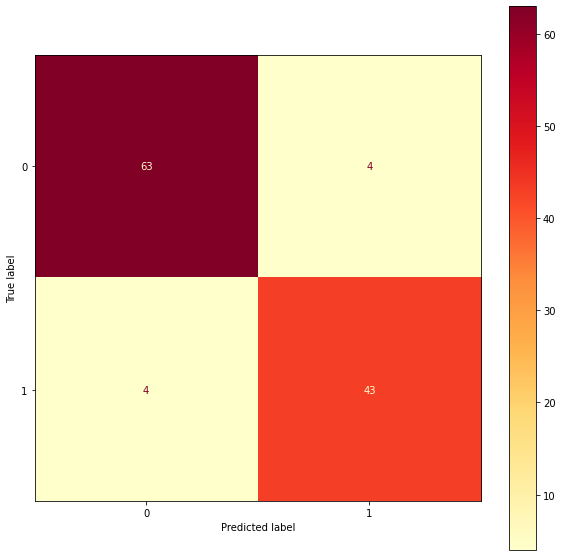

In [188]:
# Display a heat map of the confusion matrix,
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='YlOrRd')
plt.show()

                        ROC AUC: 0.9901556049539536



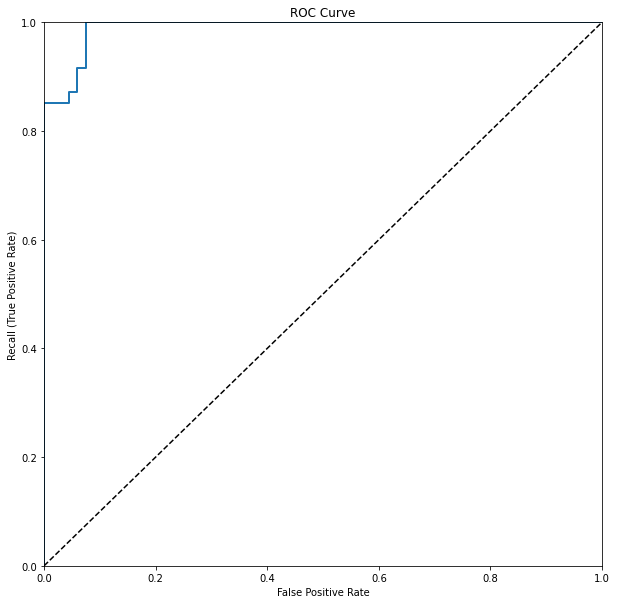

In [190]:
# Get ROC AUC and plot ROC curve.
y_pred_proba = grid_pipeline.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
print('                        ROC AUC:',roc_auc_score(y_test, y_pred_proba))
print()
plot_roc_curve(fpr, tpr)

                    AUC Precision-Recall: 0.9863155515719758



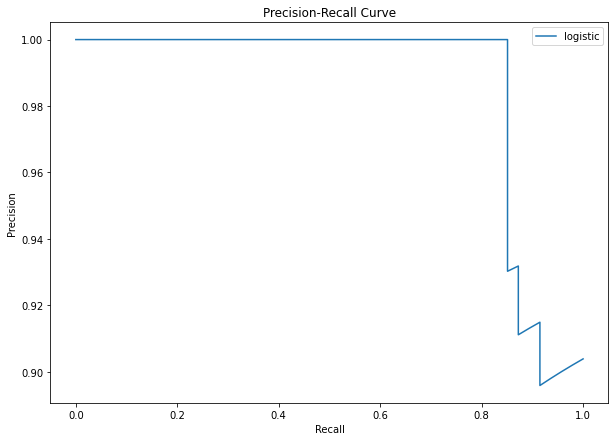

In [191]:
# Get precision-recall data.
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)
# Print AUC of precision-recall curve
print('                    AUC Precision-Recall:', auc(lr_recall, lr_precision))
print()
# Plot precision vs recall
plt.figure(figsize=(10, 7))
plt.title('Precision-Recall Curve')
plt.plot(lr_recall, lr_precision, label='logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Conclusion
Both the logistic regression and random forest with grid search models produced extremely good results with accuracies of 95% and 93% respectively, and precisions and recalls greater than 90%. Based on these numbers, the logistic regression model performed slightly better than the random forest. Unfortunately, each model resulted in 4 false negatives and false negatives are unacceptable in this particular application since a false negative means missing a breast cancer in its early stages. <br><br>
Extremely high AUC's were obtained with both models for both the ROC and the precision-recall curves. This data set has a significant target class imbalance with 357 of 569 biopsies having a diagnosis of benign vs. 212 having a malignant diagnosis (63% benign vs. 37% malignant). This imbalance suggests two things: first, the precision-recall curve is probably more reliable for evaluating results in this case and second, sampling techniques such as oversampling the minority class or undersampling the majority class may produce better results. <br><br>
This data set has been widely evaluated with numerous machine learning techniques, and accuracies approaching 100% have been achieved (Akay et al., 2009; Borges et al., 1989; DeSantis et al., 2017; Dua et al., 2017; Sahan et al., 2007).  [In another study](https://github.com/lschoch/wdbc.git), this author achieved greater than 98% accuracy using an ensemble of six models.<br><br>
One note about the grid search in this study: the parameter lists may seem somewhat limited but these lists were refined from multiple prior grid searches.
## References

- Akay, Mehmet Fatih. 2009. “Support Vector Machines Combined with Feature Selection for Breast Cancer Diagnosis.” Expert Systems with Applications 36(2). Elsevier: 3240–7.

- Borges, Lucas Rodrigues. 1989. “Analysis of the Wisconsin Breast Cancer Dataset and Machine Learning for Breast Cancer Detection.” Proceedings of XI Workshop de Visão Computacional ‐ October 05th‐07th, 2015 Group1(369).

- DeSantis, Carol E, Jiemin Ma, Ann Goding Sauer, Lisa A Newman, and Ahmedin Jemal. 2017. “Breast Cancer Statistics, 2017, Racial Disparity in Mortality by State.” CA: A Cancer Journal for Clinicians 67(6). Wiley Online Library: 439–48.

- Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.

- Şahan, Seral, Kemal Polat, Halife Kodaz, and Salih Güneş.  2007.  “A New Hybrid Method Based on Fuzzy-Artificial Immune System and K-NN Algorithm for Breast Cancer Diagnosis.” Computers in Biology and Medicine 37(3). Elsevier: 415–23.